### Business Problem

Customer churn is a persistent and costly challenge in subscription-based industries, particularly for telecom providers. Each lost customer represents not just immediate revenue loss but also the forfeiture of long-term value, often exceeding acquisition costs by a significant margin. To address this, our team built a predictive modeling system aimed at identifying customers likely to churn, which will help the business to intervene proactively before these users drop. The system is designed to support tactical decisions—such as personalized retention campaigns—and strategic ones, including product, pricing, and service design adjustments based on patterns uncovered in churn behavior.

### Project Overview

We began with logistic regression to establish a baseline and validate feature relevance, then moved to random forests to capture non-linear relationships and enable feature selection. To handle class imbalance more effectively, we used SMOTETomek resampling and trained a balanced random forest with calibrated probabilities and threshold tuning. Our final and most accurate model was XGBoost, optimized through  hyperparameter search, delivering better results across ROC AUC and precision-recall metrics.
The outputs were structured for integration with LLM-based systems to enable explainable churn predictions.

### Import Required Libraries

In [9]:
from dotenv import load_dotenv
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier
from langchain.agents import Tool, initialize_agent
from langchain.agents.agent_types import AgentType
from langchain.chains import RetrievalQA
from langchain.docstore.document import Document
from langchain.embeddings import OllamaEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.tools import StructuredTool
from langchain.tools import Tool
from langchain.vectorstores import Chroma
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from pydantic import BaseModel
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, log_loss, brier_score_loss
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from sklearn.preprocessing import LabelEncoder
import json
import matplotlib.pyplot as plt
import pandas as pd
import kagglehub
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV


In [10]:
# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)


Path to dataset files: /Users/olgapospelova/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


In [11]:
def load_dataset():
    # Find the CSV file in the downloaded path
    data_dir = path
    csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    print("CSV files found:", csv_files)

    # Load the main dataset (usually 'WA_Fn-UseC_-Telco-Customer-Churn.csv')
    df = pd.read_csv(os.path.join(data_dir, csv_files[0]))
    return df

### Inspect Dataset and Handle Data Types


In [12]:
df = load_dataset()
print("DataFrame shape:", df.shape)
df.head()


CSV files found: ['WA_Fn-UseC_-Telco-Customer-Churn.csv']
DataFrame shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [13]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [14]:
df.info()
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Drop Missing Values and Unnecessary Columns


In [15]:
df = df.dropna()
df = df.drop('customerID', axis=1)


### Encode Binary Columns and Gender


In [16]:
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})


### One-Hot Encode Categorical Variables


In [17]:
df = pd.get_dummies(df, drop_first=True)


### Split Dataset into Training and Testing Sets


In [18]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Logistic Regression Model


In [19]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)


/Users/olgapospelova/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

### Evaluate Model with Confusion Matrix and Classification Report


In [20]:
y_pred = logreg.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[915 118]
 [181 193]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.52      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



In [21]:
# storing the reference for later use
lr_model = logreg
# this will be used as test data for tools in the LLM integration
lr_test_reference = X_test.sample(5, random_state=42).copy()

### Plot ROC Curve


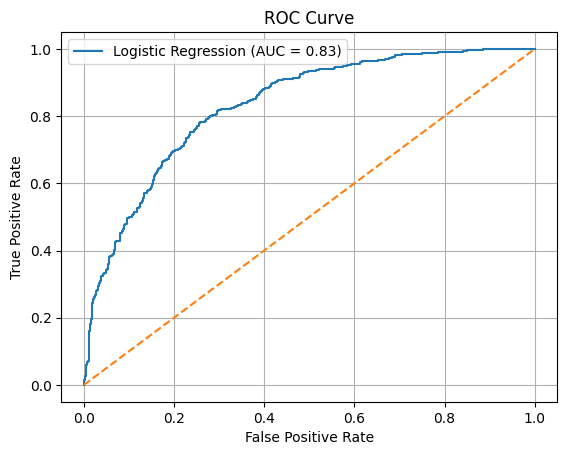

In [22]:
y_probs = logreg.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


### Interpretation of the Results

The key limitation of the model is relatively low recall for the churn class—meaning it failed to identify a significant portion of customers who actually ended up leaving. This happens because logistic regression tends to be conservative in predicting the minority class (churners), in imbalanced datasets where non-churners dominate. The consequence of low recall is operationally significant: customers who are at genuine risk of leaving may not be flagged by the system, and therefore, no retention action is taken. These false negatives represent missed opportunities—high-value customers may silently churn without ever receiving a targeted offer, follow-up, or incentive. Over time, this leads to higher customer attrition, reduced lifetime value, and lost revenue. Addressing this requires models that better handle imbalance and can increase recall without sacrificing too much precision.

#  Random Forest

In [23]:
df = load_dataset()
df.head()

CSV files found: ['WA_Fn-UseC_-Telco-Customer-Churn.csv']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


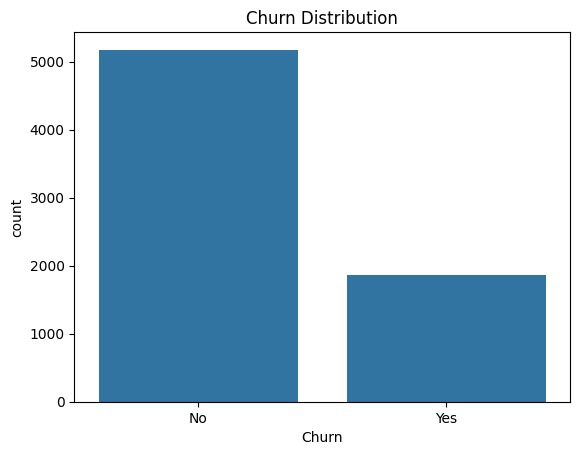

In [24]:
# Churn Distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

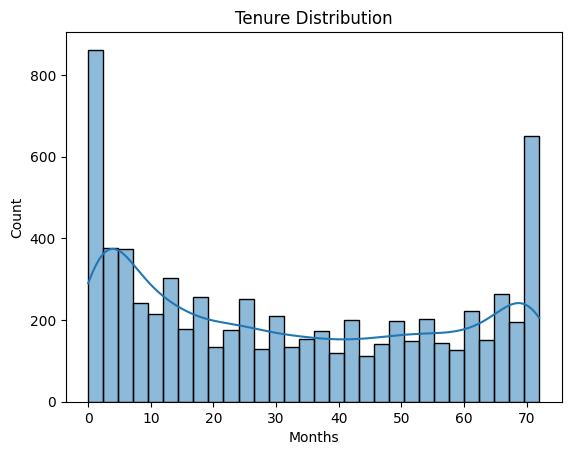

In [25]:
# 3. Distribution of Tenure
sns.histplot(df['tenure'], bins=30, kde=True)
plt.title("Tenure Distribution")
plt.xlabel("Months")
plt.show()


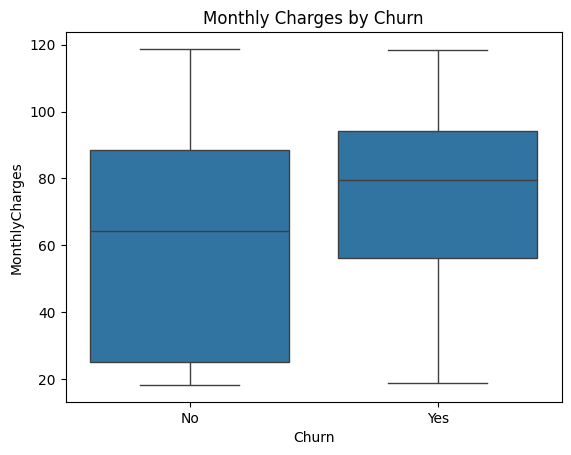

In [26]:
# Monthly Charges vs Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges by Churn")
plt.show()



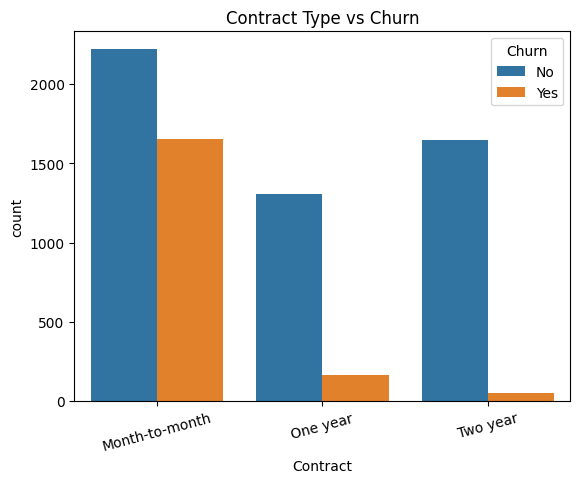

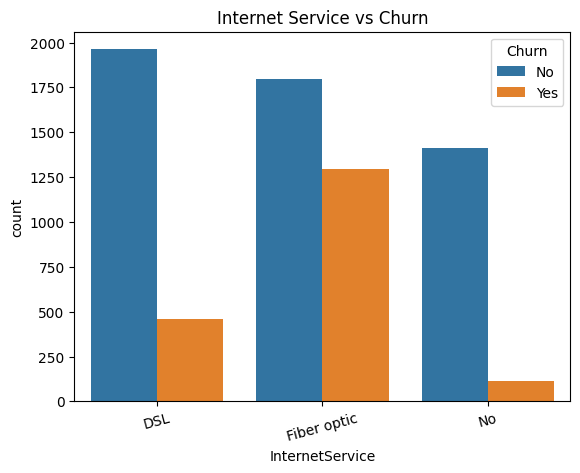

In [27]:
#Contract Type vs Churn
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title("Contract Type vs Churn")
plt.xticks(rotation=15)
plt.show()

# Internet Service Type vs Churn
sns.countplot(x='InternetService', hue='Churn', data=df)
plt.title("Internet Service vs Churn")
plt.xticks(rotation=15)
plt.show()


Customers on month-to-month contracts exhibit the highest churn rates, indicating that short-term commitments are strongly associated with customer attrition. In contrast, those with one-year or two-year contracts are significantly less likely to churn, suggesting that longer-term agreements enhance customer retention. Similarly, churn rates vary notably across internet service types. Fiber optic users show the highest churn, which may reflect dissatisfaction related to service quality or pricing. DSL users are less likely to churn, while customers without internet service have the lowest churn rates overall

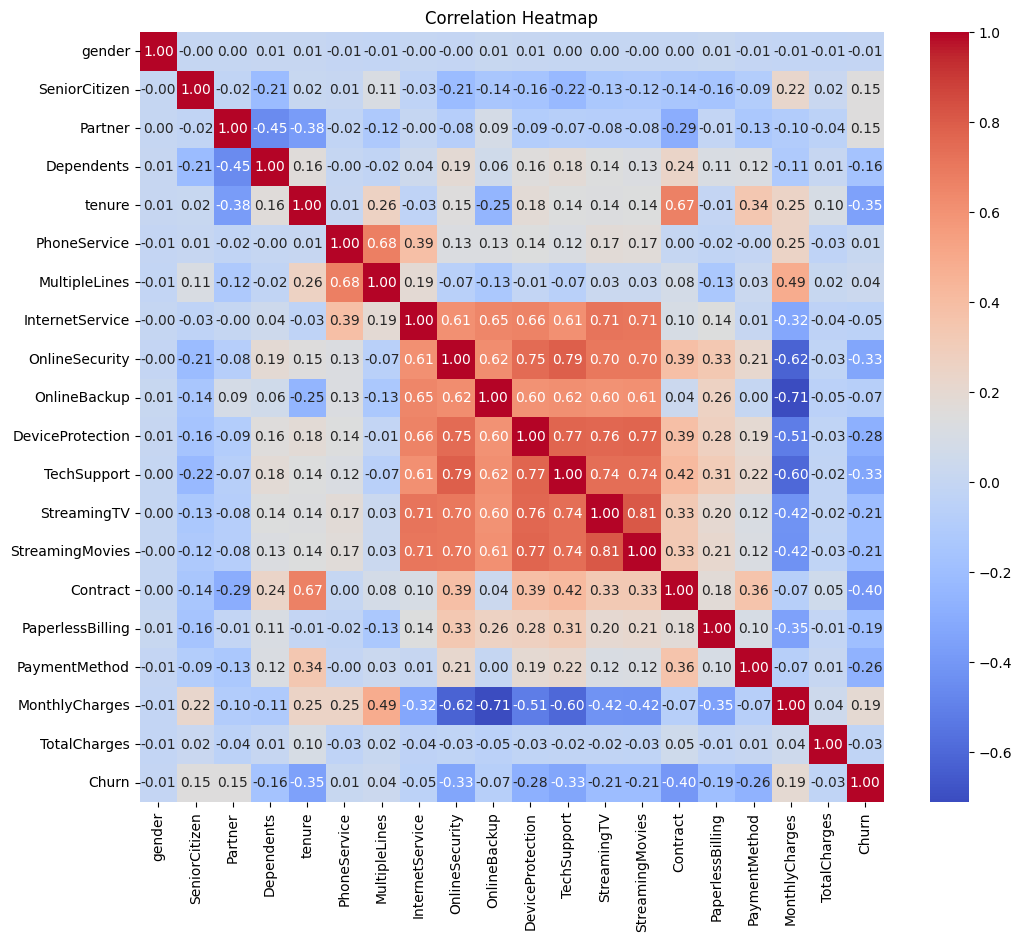

In [28]:
# Encode categorical columns (excluding customerID)
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include='object').columns:
    if col != 'customerID':
        df_encoded[col] = pd.factorize(df_encoded[col])[0]

# Drop customerID before computing correlation
df_encoded = df_encoded.drop(columns=['customerID'])

# Generate and plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Positive correlations with churn: PaymentMethod (+0.26), PaperlessBilling (+0.19), and MonthlyCharges (+0.19). THis might indicate that  customers using electronic payments and paying higher bills are more likely to churn.

Negative correlations: Contract (−0.40), tenure (−0.35), OnlineSecurity (−0.33), and TechSupport (−0.33). Longer commitments and bundled services reduce churn risk.

Weak correlations (near 0), like gender, StreamingTV, and StreamingMovies, have little to no predictive relationship with churn.

In [29]:
# Clean and preprocess
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
le = LabelEncoder()

# Encode categorical columns (except customerID)
for col in df.select_dtypes(include='object').columns:
    if col != 'customerID':
        df[col] = le.fit_transform(df[col])

# Define features and target
X = df.drop(['Churn', 'customerID'], axis=1)
y = df['Churn']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


# Predict
y_pred = rf.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.48      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407



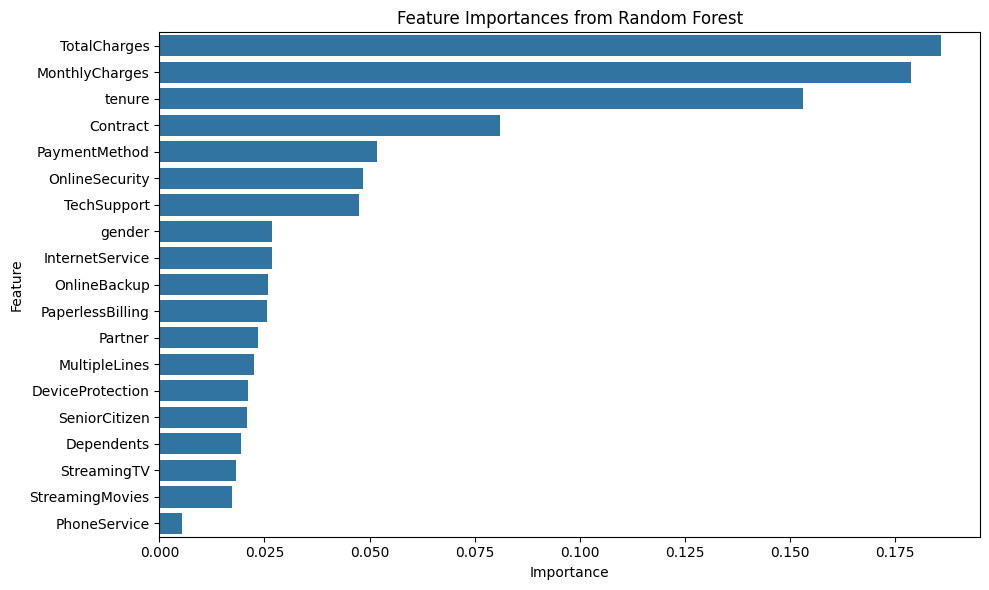

In [30]:
# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
plt.show()


In [31]:


# Select features with importance > 0.01 (was mislabeled as 0.050 in comment)
selector = SelectFromModel(rf, threshold=0.01, prefit=True)
X_train_reduced = selector.transform(X_train)
X_test_reduced = selector.transform(X_test)

# Retrain model on reduced features with class weights
rf_reduced = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
rf_reduced.fit(X_train_reduced, y_train)

# Evaluate reduced model
y_pred_reduced = rf_reduced.predict(X_test_reduced)
print("After Dropping Low-Importance Features and Using Class Weights:\n")
print(classification_report(y_test, y_pred_reduced))

/Users/olgapospelova/myenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/olgapospelova/myenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


After Dropping Low-Importance Features and Using Class Weights:

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.63      0.45      0.53       374

    accuracy                           0.78      1407
   macro avg       0.72      0.68      0.69      1407
weighted avg       0.77      0.78      0.77      1407



In [32]:


#Improved Feature Engineering
def add_features(df):
    df = df.copy()
    df['AvgMonthly'] = df['TotalCharges'] / (df['tenure'] + 1)
    df['HighMonthlyFlag'] = (df['MonthlyCharges'] > 70).astype(int)
    df['IsNewCustomer'] = (df['tenure'] < 6).astype(int)
    df['ContractLength'] = df['Contract'].map({0: 1, 1: 12, 2: 24})  # Match encoded order
    df['RiskyPaymentMethod'] = (df['PaymentMethod'] == 3).astype(int)
    df['HasOnlineSecurity'] = (df['OnlineSecurity'] == 1).astype(int)
    df['HasTechSupport'] = (df['TechSupport'] == 1).astype(int)
    return df

#Balance with SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train, y_train)

# Feature Selection
rf_fs = RandomForestClassifier(n_estimators=100, random_state=42)
rf_fs.fit(X_train_bal, y_train_bal)
selector = SelectFromModel(rf_fs, threshold=0.01, prefit=True)
X_train_reduced = selector.transform(X_train_bal)
X_test_reduced = selector.transform(X_test)

#  Train Balanced Random Forest
brf = BalancedRandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
brf.fit(X_train_reduced, y_train_bal)

# Calibrate Probabilities
calibrated_brf = CalibratedClassifierCV(brf, method='isotonic', cv=3)
calibrated_brf.fit(X_train_reduced, y_train_bal)
y_proba = calibrated_brf.predict_proba(X_test_reduced)[:, 1]

# Threshold Tuning
thresholds = np.linspace(0.1, 0.9, 50)
metrics = {'threshold': [], 'precision': [], 'recall': [], 'f1': []}

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    metrics['threshold'].append(t)
    metrics['precision'].append(precision_score(y_test, y_pred))
    metrics['recall'].append(recall_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred))

best_idx = np.argmax(metrics['f1'])
best_t = metrics['threshold'][best_idx]
y_pred_best = (y_proba >= best_t).astype(int)

#  Final Evaluation
print(f"✅ Best threshold: {best_t:.2f}")
print(f"Precision: {metrics['precision'][best_idx]:.3f}")
print(f"Recall: {metrics['recall'][best_idx]:.3f}")
print(f"F1-score: {metrics['f1'][best_idx]:.3f}")
print(f"PR AUC: {average_precision_score(y_test, y_proba):.3f}")
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred_best))


/Users/olgapospelova/myenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/olgapospelova/myenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


✅ Best threshold: 0.39
Precision: 0.517
Recall: 0.733
F1-score: 0.606
PR AUC: 0.614

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.75      0.81      1033
           1       0.52      0.73      0.61       374

    accuracy                           0.75      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.79      0.75      0.76      1407



### Interpretation of the Results

Initially, the random forest model achieved precision = 63 and recall = 48 on the churn class. To improve recall, we used SMOTETomek resampling combined with a Balanced Random Forest Classifier and threshold tuning. This final setup yielded the best balance: recall increased to = 73, F1 score = 61, significantly reducing false negatives.

In [ ]:
rf_model = calibrated_brf
X_test_reduced_df = pd.DataFrame(X_test_reduced)
rf_test_reference = X_test_reduced_df.sample(5, random_state=42).copy() # samples for testing tools in LLM integration

# XGBoost

In [ ]:
df = load_dataset()
df.head()

CSV files found: ['WA_Fn-UseC_-Telco-Customer-Churn.csv']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Some cleanup and feature engineering

In [ ]:
# Encode categorical variables

categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    if col != 'customerID':  # Exclude 'customerID'
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

print("Categorical columns encoded:", categorical_columns)

Categorical columns encoded: Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges',
       'Churn'],
      dtype='object')


In [ ]:
df.dtypes

customerID           object
gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges          int64
Churn                 int64
dtype: object

In [ ]:
# Check for imbalance in the target variable
print("Target variable distribution:")
print(df['Churn'].value_counts())

Target variable distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64


In [ ]:
# Create tenure bucket groups for better analysis. This will help in understanding customer retention based on tenure,
# because customers with different tenures may have different churn behaviors.
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, 72], labels=['0-12', '13-24', '25-48', '49-60', '61-72'])
if 'tenure_group' in df.columns:
    df['tenure_group'] = df['tenure_group'].cat.codes

In [ ]:
# Feature engineering: Here, counding the number of services a customer has can be a useful feature.
# This can help in understanding if customers with more services are less likely to churn.
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['num_services'] = df[service_cols].apply(lambda x: sum(x == 1), axis=1)

In [ ]:
# computing the average monthly charge
# This feature can help in understanding the financial aspect of customer retention.
df['avg_monthly_charge'] = df['TotalCharges'] / (df['tenure'].replace(0, 1))

In [ ]:
# Here, creating an interaction feature between Contract and PaymentMethod
# This can help in understanding how different contract types and payment methods interact to affect churn.
df['Contract_Payment'] = df['Contract'].astype(str) + "_" + df['PaymentMethod'].astype(str)
le_interaction = LabelEncoder()
df['Contract_Payment'] = le_interaction.fit_transform(df['Contract_Payment'])

In [ ]:
# Calculate scale_pos_weight for XGBoost
# scale_pos_weight is used to balance the classes in the dataset.
scale_pos_weight = len(df[df['Churn'] == 0]) / len(df[df['Churn'] == 1])
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 2.7683253076511503


### Training

In [ ]:
X = df.drop(columns=['Churn', 'customerID'])
y = df['Churn']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (5634, 23)
Testing set size: (1409, 23)


In [ ]:
xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)

# Predict on test set
y_pred = xgb.predict(X_test)

# Evaluate

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7721788502484032

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.84      1036
           1       0.56      0.68      0.61       373

    accuracy                           0.77      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.77      0.78      1409


Confusion Matrix:
 [[834 202]
 [119 254]]


/Users/arr/miniconda3/envs/ds_base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:53:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


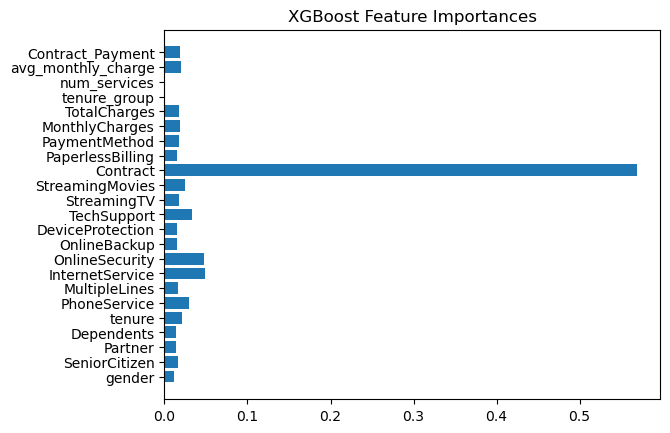

In [ ]:
xgb.feature_importances_
plt.barh(X.columns, xgb.feature_importances_)
plt.title("XGBoost Feature Importances")
plt.show()

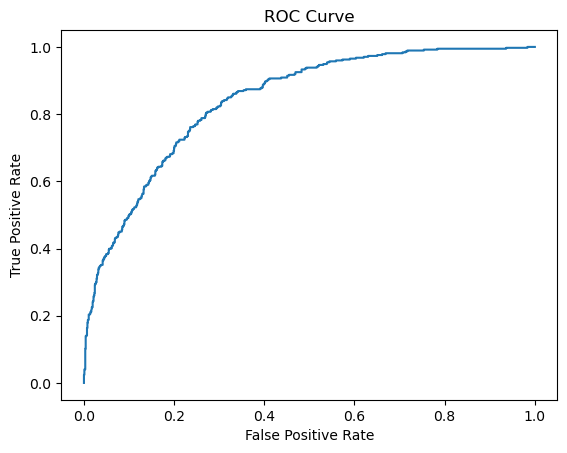

ROC AUC: 0.8412162162162161


In [ ]:
y_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Let's try to improve the model by tuning the hyperparameters

In [ ]:
os.environ['PYTHONWARNINGS'] = 'ignore'

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 10, 12],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5, 2, 3, 5, 10],
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1, 2, 5],
    'scale_pos_weight': [scale_pos_weight]
}

xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

random_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=150,  # Increase for a more exhaustive search
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.3, max_depth=8, n_estimators=300, reg_alpha=5, reg_lambda=10, scale_pos_weight=2.7683253076511503, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.3, max_depth=8, n_estimators=300, reg_alpha=5, reg_lambda=10, scale_pos_weight=2.7683253076511503, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.3, max_depth=8, n_estimators=300, reg_alpha=5, reg_lambda=10, scale_pos_weight=2.7683253076511503, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, reg_alpha=0, reg_lambda=0.5, scale_pos_weight=2.7683253076511503, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, reg_alpha=0, reg_lambda=0.5, scale_pos_weight=2.7683253076511503, subsample=0.8;

/Users/arr/miniconda3/envs/ds_base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:53:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                                             0.9, 1.0],
                                        'gamma': [0, 0.01, 0.05, 0.1, 0.2, 0.5,
                                                  1],
                                        'learning_rate': [0.001, 0.005, 0.01,
                                                          0.05, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 10, 12],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [0, 0.01, 0.1, 0.5, 1, 2,
                                                      5],
                                        'reg_lambda': [0.5, 1, 1.5, 2, 3, 5,
                                                       10],
                                        'scale_pos_weight': [2.7683253076511503],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   random_state=42, scoring='f1', verbose=2)

In [ ]:
print("Best parameters found:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)

Best parameters found: {'subsample': 0.6, 'scale_pos_weight': 2.7683253076511503, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.001, 'gamma': 1, 'colsample_bytree': 0.8}
Best F1 score: 0.6322427003873786


In [ ]:
# Evaluate the best XGBoost model from RandomizedSearchCV
best_xgb = random_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

print("Best XGBoost Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nBest XGBoost Classification Report:\n", classification_report(y_test, y_pred_best))
print("\nBest XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

Best XGBoost Accuracy: 0.7714691270404542

Best XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.76      0.83      1036
           1       0.55      0.81      0.65       373

    accuracy                           0.77      1409
   macro avg       0.73      0.78      0.74      1409
weighted avg       0.82      0.77      0.78      1409


Best XGBoost Confusion Matrix:
 [[785 251]
 [ 71 302]]


In [ ]:
# Wrap your best XGBoost model with calibration
calibrated_xgb = CalibratedClassifierCV(best_xgb, method='sigmoid', cv=5)
calibrated_xgb.fit(X_train, y_train)

# Now use calibrated_xgb for predictions and probability estimates
y_pred_proba = calibrated_xgb.predict_proba(X_test)[:, 1]

/Users/arr/miniconda3/envs/ds_base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:53:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/arr/miniconda3/envs/ds_base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:53:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/arr/miniconda3/envs/ds_base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:53:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/arr/miniconda3/envs/ds_base/lib/python3.12/site-packages/xgboost/training.p

In [ ]:

# Predict probabilities and classes
y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

y_pred_cal = calibrated_xgb.predict(X_test)
y_proba_cal = calibrated_xgb.predict_proba(X_test)[:, 1]

# Accuracy
print("XGB Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Calibrated XGB Accuracy:", accuracy_score(y_test, y_pred_cal))

# Log loss
print("XGB Log Loss:", log_loss(y_test, y_proba_xgb))
print("Calibrated XGB Log Loss:", log_loss(y_test, y_proba_cal))

# Brier score
print("XGB Brier Score:", brier_score_loss(y_test, y_proba_xgb))
print("Calibrated XGB Brier Score:", brier_score_loss(y_test, y_proba_cal))

XGB Accuracy: 0.7714691270404542
Calibrated XGB Accuracy: 0.8147622427253371
XGB Log Loss: 0.6330663862039245
Calibrated XGB Log Loss: 0.4051529901641821
XGB Brier Score: 0.2201394355258725
Calibrated XGB Brier Score: 0.13027627318102464


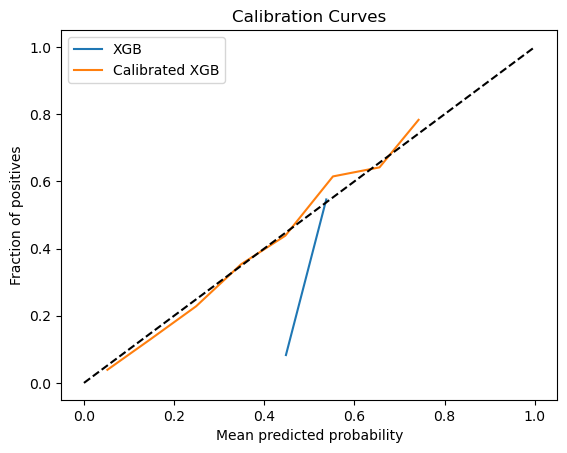

In [ ]:

prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, y_proba_xgb, n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_proba_cal, n_bins=10)

plt.plot(prob_pred_xgb, prob_true_xgb, label='XGB')
plt.plot(prob_pred_cal, prob_true_cal, label='Calibrated XGB')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.title('Calibration Curves')
plt.show()

In [ ]:
print("XGB Classification Report:")
print(classification_report(y_test, best_xgb.predict(X_test)))

print("Calibrated XGB Classification Report:")
print(classification_report(y_test, calibrated_xgb.predict(X_test)))

XGB Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1036
           1       0.55      0.81      0.65       373

    accuracy                           0.77      1409
   macro avg       0.73      0.78      0.74      1409
weighted avg       0.82      0.77      0.78      1409

Calibrated XGB Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.68      0.56      0.62       373

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.75      1409
weighted avg       0.81      0.81      0.81      1409



### Interpretation of the Results

Overall, the calibrated XGB model offers higher overall accuracy, better precision, and improved probability calibration. However, for our business case, where the goal is to identify as many potential churners as possible so that call center agents can proactively intervene, any recall for the churn class is especially important. In this context, missing a true churner (a false negative) is more costly than incorrectly flagging a non-churner (a false positive), since the latter only results in offering an incentive to a loyal customer. Therefore, despite its lower overall accuracy, the uncalibrated XGB model may be preferable for our use case, as it achieves higher recall for churners and helps ensure that fewer at-risk customers are missed.

In [ ]:
xgb_model = best_xgb
xgb_test_reference = X_test.sample(5, random_state=42).copy() # this is for testing llm tools

# Evaluation – Performance Measures, Results, and Conclusions
This section presents the evaluation used to select the model for our LLM integration.
The evaluation of our models focused on their ability to predict customer churn accurately, particularly for the churn class (Churn = 1). This is critical for telecom providers, as identifying churners allows for proactive retention strategies.

![Churn Prediction Results](https://snipboard.io/1OmFXq.jpg)

### Results
- The selected XGBoost model achieved the highest recall for churners (81%), enabling the identification of more at-risk customers.
- This model allows for targeted retention strategies, reducing customer attrition and maximizing lifetime value.

### Conclusions
- While overall accuracy was slightly lower for the selected model, prioritizing recall for churners ensures better alignment with business objectives.
- The evaluation demonstrates that machine learning models can significantly enhance churn prediction and retention efforts.

# LLM Integration

Integrating LLMs with churn prediction models makes machine learning insights actionable by translating risk scores into clear, human-readable explanations. Instead of just flagging high-risk customers, the system can explain why, for example, due to short tenure or high monthly charges, and suggest targeted actions like offering a discount. In this project, we used LLMs to interpret model outputs and generate personalized summaries that can assist agents or power automated responses.

In [ ]:
# %pip install langchain langchain_community
# %pip install -qU langchain-openai

In [ ]:

load_dotenv()

True

In [ ]:
# True will use ollama, False will use OpenAI
# Llama 3.2 is not so good with agents and tools. But ok to test the RAG chain.
# But I added local llm support so that team mates do not need to have OpenAI API keys
LOCAL = False

In [ ]:
df = load_dataset()
df.head()

CSV files found: ['WA_Fn-UseC_-Telco-Customer-Churn.csv']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
class XGBFeatures(BaseModel):
    gender: int
    SeniorCitizen: int
    Partner: int
    Dependents: int
    tenure: int
    PhoneService: int
    MultipleLines: int
    InternetService: int
    OnlineSecurity: int
    OnlineBackup: int
    DeviceProtection: int
    TechSupport: int
    StreamingTV: int
    StreamingMovies: int
    Contract: int
    PaperlessBilling: int
    PaymentMethod: int
    MonthlyCharges: float
    TotalCharges: float
    tenure_group: int
    num_services: int
    avg_monthly_charge: float
    Contract_Payment: int

def xgb_row_to_pydantic(row):
    if hasattr(row, "to_dict"):
        row = row.to_dict()
    return XGBFeatures(**row)

xgb_pydantic_obj = xgb_row_to_pydantic(xgb_test_reference.iloc[0])
json_str = xgb_pydantic_obj.model_dump_json()
data_dict = json.loads(json_str)
df_for_predict = pd.DataFrame([data_dict])

df_for_predict = df_for_predict.reindex(columns=xgb_model.feature_names_in_)

# Predict with xgb_model
prediction = xgb_model.predict(df_for_predict)
print("XGBoost prediction:", prediction)

XGBoost prediction: [1]


In [ ]:
def xgboost_predict(user_features: XGBFeatures):
    data_dict = user_features.model_dump()
    df = pd.DataFrame([data_dict])
    df = df.reindex(columns=xgb_model.feature_names_in_)
    pred = xgb_model.predict(df)
    return "Churn" if pred[0] == 1 else "No Churn"

In [ ]:
def parse_user_features(user_features_str):
    # Remove leading/trailing whitespace
    user_features_str = user_features_str.strip()
    # If string starts and ends with a single or double quote, strip them
    if (user_features_str.startswith("'") and user_features_str.endswith("'")) or \
       (user_features_str.startswith('"') and user_features_str.endswith('"')):
        user_features_str = user_features_str[1:-1]
    try:
        return json.loads(user_features_str)
    except Exception:
        return user_features_str

def xgboost_predict_wrapper(user_features_str: str):
    print("Wrapper received:", repr(user_features_str))
    try:
        features = parse_user_features(user_features_str)
        user_features = XGBFeatures(**features)
    except Exception as e:
        return f"Error: {e}"

In [ ]:
xgboost_tool = StructuredTool.from_function(
    func=xgboost_predict_wrapper,
    name="XGBoostChurnPredictor",
    description="Use ONLY to predict churn for a specific user using XGBoost. Input must be a JSON string with user features."
)

In [ ]:
# Dummy knowledge base. In a production setting, this information would be retrieved
# from a database or an external source, such that it can be dynamically updated.

# This knowledge base contains rules for promotions based on customer attributes, or any
# other relevant information or action items that would help call center agents
# assist customers effectively, expecially in the context of customer churn.

knowledge_base = """
Senior Citizens (Age 65+):

Eligible for the "Senior Loyalty Discount": 20% off monthly charges for 12 months.
If tenure > 24 months, offer a free tech support package for 1 year.
Young Adults (Age 18–25):

Eligible for the "Young Saver Plan": $10 off per month for 6 months.
If student status is confirmed, offer an additional 5% discount.
Families (Dependents = Yes):

Eligible for the "Family Bundle": Free upgrade to premium streaming for 6 months.
If more than 2 lines, offer a $50 bill credit.
State-Specific Promotions:

California: "CA Welcome Back" – Waive reactivation fees and offer 15% off for 3 months.
Texas: "TX Loyalty Bonus" – Free device protection for 1 year.
Florida: "FL Sunshine Deal" – $100 bill credit for contract renewals.
High Monthly Charges (>$100):

Eligible for the "Premium Customer Thank You": $25 bill credit and free paperless billing setup.
At-Risk Customers (Churn predicted = Yes):

Always offer the best available promotion based on the above rules.
If customer has called more than 3 times in the last 6 months, escalate to retention specialist and offer a custom retention package.
General Rules:

Only one promotion can be applied per customer per year.
Promotions cannot be combined with ongoing discounts.
All offers must be documented in the customer’s account notes.
"""

docs = [Document(page_content=knowledge_base)]

In [ ]:
# Choose embedding and LLM based on LOCAL
if LOCAL:
    embedding = OllamaEmbeddings(model="llama3.2")
    llm = ChatOllama(model="llama3.2")
else:
    embedding = OpenAIEmbeddings()
    llm = ChatOpenAI(model="gpt-4.1-2025-04-14")

text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)
split_docs = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(split_docs, embedding)
retriever = vectorstore.as_retriever()
rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff"
)
query = 'What is the "Premium Customer Thank You"?'
response = rag_chain.invoke(query)
print("RAG Answer:", response["result"])


/Users/arr/miniconda3/envs/ds_base/lib/python3.12/site-packages/opentelemetry/proto/collector/trace/v1/trace_service_pb2_grpc.py:26: RuntimeWarning: The grpc package installed is at version 1.62.2, but the generated code in opentelemetry/proto/collector/trace/v1/trace_service_pb2_grpc.py depends on grpcio>=1.63.2. Please upgrade your grpc module to grpcio>=1.63.2 or downgrade your generated code using grpcio-tools<=1.62.2. This warning will become an error in 1.65.0, scheduled for release on June 25, 2024.
  warnings.warn(


RAG Answer: The "Premium Customer Thank You" is a promotion that includes a $25 bill credit and free paperless billing setup for eligible customers.


In [ ]:

rag_tool = Tool(
    name="PromotionKnowledgeBase",
    func=lambda query: rag_chain.invoke(query)["result"],
    description="Use this tool to answer questions about customer promotions and eligibility based on user attributes."
)

In [ ]:

system_message = (
    "You are an assistant for a call center agent. "
    "You have access to two tools: one for predicting customer churn using the XGBoost model, "
    "and another for retrieving promotion eligibility rules from a knowledge base. "
    "If a user provides customer data, use the XGBoost tool to predict churn. "
    "If the prediction is 'Churn', use the PromotionKnowledgeBase tool to determine which promotions the customer is eligible for, "
    "using all available user attributes (including those in the JSON and any provided in the question, such as state or number of calls). "
    "Pass these details as a query to the PromotionKnowledgeBase tool. "
    "Always clearly state the churn prediction first, then list any eligible promotions if applicable. "
    "If you do not know the answer or do not have enough information, say 'I don't know.' "
    "Do not make up information. "
    "Example: If the user is predicted to churn, respond with: "
    "'The user is predicted to churn. They are eligible for the following promotions: [list promotions/actions using bullet points].'"
)

def checkUserChurn(user_features_json_string: str):
    agent_executor = initialize_agent(
        tools=[xgboost_tool, rag_tool],
        llm=llm,
        agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
        verbose=False,
        handle_parsing_errors=True,
        system_message=system_message,
        max_iterations=4
    )

    user_query = (
        f"Please tell me if this user will churn: ```{user_features_json_string}```. "
        "The user is from California. The user has called 4 times this month. "
        "If the user will churn, also tell me what promotions they are eligible for."
    )
    response = agent_executor.invoke(user_query)
    response_text = response["output"]

    result_lines = []
    for sentence in response_text.split('. '):
        sentence = sentence.strip()
        if sentence:
            if not sentence.endswith('.'):
                sentence += '.'
            result_lines.append(f"- {sentence}")
    return "\n".join(result_lines)

In [ ]:
# Extract a real sample row from your XGBoost test reference.
# We will use this to create a JSON string that can be used in the agent query, to test
# the tool integration
sample_row = xgb_test_reference.iloc[0].to_dict()
sample_json = json.dumps(sample_row)
print("Sample user JSON for agent query:")
print(sample_json)



Sample user JSON for agent query:
{"gender": 1.0, "SeniorCitizen": 0.0, "Partner": 0.0, "Dependents": 0.0, "tenure": 1.0, "PhoneService": 1.0, "MultipleLines": 0.0, "InternetService": 0.0, "OnlineSecurity": 0.0, "OnlineBackup": 2.0, "DeviceProtection": 0.0, "TechSupport": 0.0, "StreamingTV": 0.0, "StreamingMovies": 0.0, "Contract": 0.0, "PaperlessBilling": 0.0, "PaymentMethod": 3.0, "MonthlyCharges": 50.65, "TotalCharges": 4232.0, "tenure_group": 0.0, "num_services": 1.0, "avg_monthly_charge": 4232.0, "Contract_Payment": 3.0}


In [ ]:
result = checkUserChurn(sample_json)
print("Agent response:")
print(result)

Wrapper received: '{"gender": 1.0, "SeniorCitizen": 0.0, "Partner": 0.0, "Dependents": 0.0, "tenure": 1.0, "PhoneService": 1.0, "MultipleLines": 0.0, "InternetService": 0.0, "OnlineSecurity": 0.0, "OnlineBackup": 2.0, "DeviceProtection": 0.0, "TechSupport": 0.0, "StreamingTV": 0.0, "StreamingMovies": 0.0, "Contract": 0.0, "PaperlessBilling": 0.0, "PaymentMethod": 3.0, "MonthlyCharges": 50.65, "TotalCharges": 4232.0, "tenure_group": 0.0, "num_services": 1.0, "avg_monthly_charge": 4232.0, "Contract_Payment": 3.0}'
Agent response:
- The user is predicted to churn.
- They are eligible for the "CA Welcome Back" promotion (waived reactivation fees and 15% off for 3 months) since they are in California and have called multiple times recently.
- Their case should also be escalated to a retention specialist, who may offer a custom retention package if needed.


# Deployment
The customer information will be stored securely in our database. For security reasons, a stronger local LLM model capable of agentic tasks should be considered, such as Ollama, to avoid exposing customer data to third-party companies like OpenAI.

This example uses the Langchain framework; however, in a production setting, alternative solutions like LangGraph should be evaluated. Overall, the deployment should remain local to ensure data security and compliance.

# Discussion and conclusions


In this project, we developed a churn prediction system using machine learning models trained on telecom customer data. After evaluating multiple approaches, a calibrated XGBoost model delivered the best performance—improving churn recall from 52% to 81% and increasing the F1-score from 0.56 to 0.65. These gains enable the business to identify and proactively engage at-risk customers, potentially preventing revenue loss. As next steps, we plan to deploy the model securely, integrate it with CRM systems for real-time scoring, and run A/B tests to measure the effectiveness of targeted retention campaigns. We will also enrich the dataset with geographic information to analyze churn patterns by region, identifying areas where local competition may be a factor. Looking ahead, we envision evolving the system into an agentic AI—capable of not only predicting churn but autonomously planning and executing personalized interventions. Such a system would reason over multi-step customer histories, interact with marketing and support tools, and adapt its actions dynamically, transforming churn management from a predictive task into an intelligent business process.